### This notebook shows how to classify diffraction pattern signal quality using deep neural networks and the Deep freak dataset. 

### We demonstrate how to load the dataset and go through the basic machine learning workflow

- Examine the data
- Define the metrics to optimize
- Train the model
- Test the model
- Tune model parameters


### Import machine learning tools: pytorch and other librairies

In [1]:
import os
import torch
from torch import nn
from torch import optim
import sklearn.datasets
import sklearn.metrics
import numpy as np
from data.dataset import DiffraNetDataset
from torchvision import transforms, utils
from torch.utils.data import DataLoader
from model.deep_freak import get_classifier

import matplotlib.pyplot as plt

from statistics import mean
import copy



%matplotlib inline

In [2]:
np.random.seed(0)
torch.manual_seed(0)

num_classes = 2
EPOCHS = 100
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### We first begin by examining the dataset. It contains diffraction images acquired under various conditions.
### The synthetic training data is devided in 5 sub-directories one per class:
    data/
        Synthetic/
            train/
                1/
                2/
                3/
                4/
                5/
            validation/
            test/

#### The 5 classes are: [“blank”, “no-crystal”, “weak”, “good”, “strong”] 

In [3]:
from PIL import Image

In [4]:
image_paths = ["./data/synthetic/train/1/fake_00030.png", "./data/synthetic/train/2/fake_00032.png", 
               "./data/synthetic/train/3/fake_00035.png", "./data/synthetic/train/4/fake_00033.png",
               "./data/synthetic/train/5/fake_00047.png"]

##### example of a blank image pattern

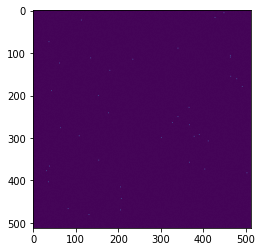

In [5]:
img = Image.open(image_paths[0])

plt.imshow(img)

#### example of an image with a visible signal but no crystal

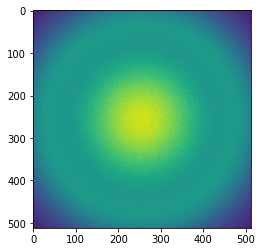

In [6]:
img = Image.open(image_paths[1])

plt.imshow(img)

#### Example of a weak diffraction signal of a crystal 

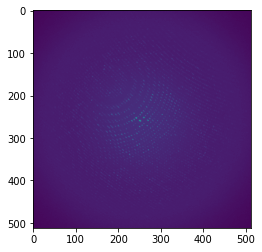

In [7]:
img = Image.open(image_paths[2])

plt.imshow(img)

#### Example of a with a good diffraction signal of crystal

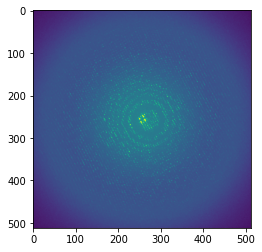

In [8]:
img = Image.open(image_paths[3])

plt.imshow(img)

#### The optimal signal possible is that of a strong signal from a crystal

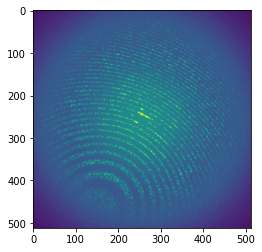

In [9]:
img = Image.open(image_paths[4])

plt.imshow(img)

In [10]:
def count_subfolder(path):
    files = folders = 0
    
    for _, dirnames, filenames in os.walk(path):
        files += len(filenames)
        folders += len(dirnames)
    return files


### The number of elements of each class is well balanced and suggests accuracy would be a sufficent metric for this problem

In [11]:
paths = ["./data/synthetic/train/1/", "./data/synthetic/train/2/", "./data/synthetic/train/3/", 
         "./data/synthetic/train/4/", "./data/synthetic/train/5/"]

print("number of blank signal:", count_subfolder(paths[0]))
print("number of no crystal:", count_subfolder(paths[1]))
print("number of weak signal:", count_subfolder(paths[2]))
print("number of good signal:", count_subfolder(paths[3]))
print("number of strong signal:", count_subfolder(paths[4]))


number of blank signal: 1485
number of no crystal: 2734
number of weak signal: 2743
number of good signal: 2012
number of strong signal: 1026


In [12]:
data_dir = "./data/"
path2weights = "./model/weights.pt"
data_transformer = transforms.Compose([transforms.ToTensor(),transforms.Normalize(0.5, 0.5)])

# Model Training Phase

## Given the time cost of this part it can be skipped at first. The section on inference provides a demo using a pretrained model.

### Loading the training and validation datasets

In [13]:
train_ds1 = DiffraNetDataset(data_dir, data_transformer)
train_ds2 = DiffraNetDataset(data_dir, data_transformer, data_type="real_preprocessed", phase="validation")
val_ds = DiffraNetDataset(data_dir, transform=data_transformer, data_type="real_preprocessed", phase="test")

train_dl1 = DataLoader(train_ds1, batch_size=8, shuffle=True)
train_dl2 = DataLoader(train_ds2, batch_size=8, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=8, shuffle=True)

path to data:  ./data/synthetic/train
path to data:  ./data/real_preprocessed/validation
path to data:  ./data/real_preprocessed/test


### Metrics and training loop

### This part contains the training metrics for the network. We are mainly concerned with model accuracy which is the proportion of correctly classifed images

In [14]:
def metrics_batch(output, target):
    pred = output.argmax(dim=1, keepdim=True)
    corrects = pred.eq(target.view_as(pred)).sum().item()
    return corrects

def loss_batch(loss_func, output, target, opt=None):
    loss = loss_func(output, target)
    metric_b = metrics_batch(output, target)
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()
    
    return loss.item(), metric_b

In [15]:
def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):
    running_loss = 0.0
    running_metric = 0.0
    len_data = len(dataset_dl.dataset)
    for X, y in dataset_dl:
        X = X.to(device)
        y = y.to(device)
        output = model(X)
        loss_b, metric_b=loss_batch(loss_func, output, y, opt)
        running_loss += loss_b
        if metric_b is not None:
            running_metric += metric_b
        if sanity_check is True:
            break
    
    loss = running_loss / float(len_data)
    metric = running_metric/float(len_data)
    return loss, metric

In [16]:
model = get_classifier(num_classes, device)
loss_func = nn.CrossEntropyLoss(reduction="sum")
optimizer = optim.Adam(model.parameters(), lr=1e-4)

loss_history = {
    "train": [],
    "val": [],
}

metric_history = {
    "train": [],
    "val": [],
}


In [17]:
EPOCHS

100

In [18]:
def train_model_on_dataset(training_dl):
    best_loss = 10
    for epoch in range(EPOCHS):
        running_loss = []
        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, training_dl, opt=optimizer)
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)

        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl)
            loss_history["val"].append(val_loss)
            metric_history["val"].append(val_metric)

            if val_loss < best_loss:
                best_loss = val_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), path2weights)
                print("Copied best model weights!")

        print("train loss: %.6f, dev loss: %.6f, accuracy: %.2f" %(train_loss,val_loss,100*val_metric))
        print("-"*10)

In [ ]:
train_model_on_dataset(train_dl1)

Copied best model weights!
train loss: 0.102179, dev loss: 1.928966, accuracy: 59.34
----------
train loss: 0.059454, dev loss: 1.931373, accuracy: 58.24
----------
Copied best model weights!
train loss: 0.055710, dev loss: 1.800985, accuracy: 60.44
----------
train loss: 0.051925, dev loss: 2.419421, accuracy: 58.24
----------
train loss: 0.045600, dev loss: 2.549704, accuracy: 58.24
----------
train loss: 0.039808, dev loss: 2.627657, accuracy: 60.44
----------
train loss: 0.037444, dev loss: 2.677931, accuracy: 57.14
----------
train loss: 0.032239, dev loss: 2.463220, accuracy: 61.54
----------
train loss: 0.028767, dev loss: 2.817923, accuracy: 59.34
----------
train loss: 0.024668, dev loss: 2.607695, accuracy: 60.44
----------
train loss: 0.017474, dev loss: 3.163620, accuracy: 59.34
----------
train loss: 0.013848, dev loss: 2.591161, accuracy: 62.64
----------
train loss: 0.017636, dev loss: 2.476702, accuracy: 63.74
----------
train loss: 0.012392, dev loss: 2.990958, accurac

In [ ]:
train_model_on_dataset(train_dl2)

torch.save(model.state_dict(), path2weights)

plt.title("Train-Val Loss")
plt.plot(range(1, EPOCHS+1), loss_history["train"], label="train")
plt.plot(range(1, EPOCHS+1), loss_history["val"], label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

In [ ]:
plt.plot(range(1, EPOCHS+1), loss_history["train"], label="train")

In [ ]:
import json

with open('loss.json', 'w') as fp:
    json.dump(loss_history, fp,  indent=4)

In [ ]:
with open('metric.json', 'w') as fp:
    json.dump(loss_history, fp,  indent=4)

# Inference and test phase

### We can now evaluate the precision and accuracy of the model on a test dataset

In [ ]:
def metrics_batch(output, target):
    pred = output.argmax(dim=1, keepdim=True)
    corrects = pred.eq(target.view_as(pred)).sum().item()
    true_pos = (target.view_as(pred)*pred).sum().item()
    false_pos = ((1-target.view_as(pred))*pred).sum().item()
    try:
        precision = float(true_pos)/(true_pos + false_pos)
    except ZeroDivisionError:
        precision = 1
    return corrects, precision

In [ ]:
def metric_epoch(model, dataset_dl, sanity_check=False):
    running_metric = 0.0
    precs = []
    len_data = len(dataset_dl.dataset)
    for X, y in dataset_dl:
        X = X.to(device)
        y = y.to(device)
        output = model(X)
        metric_b, prec = metrics_batch(output, y) 
        running_metric += metric_b
        precs.append(prec)
        if sanity_check is True:
            break
    
    metric = running_metric/float(len_data)
    precision = np.array(precs).mean()
    
    return metric, precision

In [ ]:
model = get_classifier(num_classes, device)
model.load_state_dict(torch.load('./model/weights.pt'))
model.eval()

In [ ]:
test_ds = DiffraNetDataset(data_dir, transform=data_transformer, data_type="real_preprocessed", phase="test")
test_dl = DataLoader(test_ds, batch_size=8, shuffle=True)

In [ ]:
for epoch in range(1):
    with torch.no_grad():
        val_metric, prec = metric_epoch(model, test_dl)
        print("epoch: %.2f accuracy: %.2f" %(epoch, 100*val_metric))
        print("epoch: %.2f precision: %.2f" %(epoch, prec))
        print("-"*10)
